### Athens University of Economics and Business
### Department of Management Science & Technology
### Msc in Business Analytics

### Course : Machine Learning & Content Analytics
* ### Instructors : H.Papageorgiou, G.Perakis
* ### Students : Xheni Cobanaj (f2822117), Nikolaos Mantzakos (f2822107), Dimitris Papageorgiou (f2822109)

* Import of necessary libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Embedding,Flatten,Dropout,Activation
from tensorflow.python.keras import metrics,regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, Concatenate, Bidirectional, concatenate
from tqdm import tqdm
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score,hamming_loss,multilabel_confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/MyDrive/mbti_1.csv"

/bin/bash: ls /content/drive/MyDrive/mbti_1.csv: No such file or directory


In [5]:
df=pd.read_csv("/content/drive/MyDrive/mbti_1.csv",header=0)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
#df = pd.read_csv("mbti_1.zip",header=0)
#df.head()

In [7]:
data = df.copy()

# Data Cleaning and Preparation

In [8]:
def text_cleaning(text):
  
  # make all characters lowercase
  text = text.lower()

  # removing the posts delimiter  
  text = text.replace("|"," ") 

  # removing the urls
  text = re.sub(r'https?:\/\/.*?[\s+]', '',text)

  # removing Punctation
  text = re.sub('[%s]*' % string.punctuation, '',text)

  # removing numbers
  text = re.sub('[0-9]+','', text)
   
  # removing non-words 
  text = re.sub(r'[^a-zA-Z\s]','',text)

  # removing the personallity type codes 
  pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
  pers_types = [p.lower() for p in pers_types]
  
  for t in pers_types:
      text = text.replace(t,"")


  # removing big spaces
  text = re.sub(' +', ' ', text) 

  

  return(text)  

In [9]:
data['posts'] = data['posts'].apply(text_cleaning)

## Transforming problem to Multilabel Classification

In [10]:
# function for producing the four binary target variables
def categories(df):
  df['Extraversion'] = ''
  df['Sensing'] = ''
  df['Thinking'] = ''
  df['Judging'] = ''

  for i in df.index:    
    if "E" in df['type'][i]:
      df['Extraversion'][i] = 1
    else:
      df['Extraversion'][i] = 0

    if "S" in df['type'][i]:
      df['Sensing'][i] = 1
    else:
      df['Sensing'][i] = 0
    
    if "T" in df['type'][i]:
      df['Thinking'][i] = 1
    else:
      df['Thinking'][i] = 0
    
    if "J" in df['type'][i]:
      df['Judging'][i] = 1
    else:
      df['Judging'][i] = 0
  return(df)

In [11]:
categories(data)

,type,posts,Extraversion,Sensing,Thinking,Judging
0,INFJ,and moments sportscenter not top ten plays pr...,0,0,0,1
1,ENTP,im finding the lack of me in these posts very ...,1,0,1,0
2,INTP,good one of course to which i say i know thats...,0,0,1,0
3,INTJ,dear i enjoyed our conversation the other day ...,0,0,1,1
4,ENTJ,youre fired thats another silly misconception ...,1,0,1,1
...,...,...,...,...,...,...
8670,ISFP,ixfp just because i always think of cats as f...,0,1,0,0
8671,ENFP,soif this thread already exists someplace else...,1,0,0,0
8672,INTP,so many questions when i do these things i wou...,0,0,1,0
8673,INFP,i am very conflicted right now when it comes t...,0,0,0,0


* Making our own custom stopwords

In [12]:
corpora = " ".join(data.posts)

In [13]:
top_words = Counter(corpora.split()).most_common()

In [14]:
stop_words = set([i[0].lower() for i in top_words[:100]])

In [15]:
stop_cus = stop_words.union(set(stopwords.words('english')))
stop_cus = stop_cus = list(stop_cus)

##  Stop-Words Removal and Stemming.

In [16]:
def stopwords_stemming(x):
  ps = PorterStemmer()
  x = word_tokenize(x)
  x = [word for word in x if word not in stop_cus]
  x= [ps.stem(w) for w in x]
  x = ' '.join(x)
  return(x)

In [17]:
data['posts'] = data['posts'].apply(stopwords_stemming)

## Data Split into Train-Test-Validation

In [18]:
X = data['posts']
y = data[['Extraversion','Sensing','Thinking','Judging']]

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.1,
                                                            random_state=20,
                                                            stratify=y)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10, 
                                                  random_state=20,
                                                  stratify=y_train_val)

* Target Encoding

In [21]:
y_train_enc = np.array(y_train).astype('float32')
y_train_enc

array([[0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 1., 0.]], dtype=float32)

In [22]:
y_val_enc = np.array(y_val).astype('float32')
y_test_enc = np.array(y_test).astype('float32')

# TF-IDF Approach

In [23]:
max_words = 30000

In [24]:
tf_idf_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words= None,
    ngram_range=(1, 1), # unigrams
    max_features= max_words,
    binary=False # binary output or full counts. 
)
tf_idf_vectorizer

TfidfVectorizer(max_features=30000, strip_accents='unicode')

In [25]:
X_train_enc = tf_idf_vectorizer.fit_transform(X_train)

In [26]:
X_val_enc = tf_idf_vectorizer.transform(X_val)
X_test_enc = tf_idf_vectorizer.transform(X_test)

In [27]:
print(f'X_train encoded shape: {X_train_enc.shape}')
print(f'X_val encoded shape: {X_val_enc.shape}')
print(f'X_test encoded shape: {X_test_enc.shape}')

X_train encoded shape: (7026, 30000)
X_val encoded shape: (781, 30000)
X_test encoded shape: (868, 30000)


## Model Callbacks

In [28]:
monitor = 'val_loss'

model1_fname = 'model_ffn.h5'

callbacks_ffn = [
        
#     TensorBoard(log_dir=TENSORBOARD_LOGS_DIR,
#                 histogram_freq=0,
#                 embeddings_freq=0,
#                 write_graph=True,
#                 write_images=False),
    
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model1_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]

## Feed Forward Neural Network - Model Architecture.

In [29]:
#fnn network hyperparameters
# Number of Classes for the Y labels 
nb_classes = len(y_train_enc[0])
dropout_rate = 0.4

print('Number of Classes (Personality Components): {}'.format(nb_classes))
print('Dropout rate: {}'.format(dropout_rate))

# architecture hyperparameters
nb_epoch = 30
batch_size = 32 

Number of Classes (Personality Components): 4
Dropout rate: 0.4


In [30]:
print('Building Model...')
model_ffn = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(max_words,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(nb_classes),
    tf.keras.layers.Activation('sigmoid'),

])
model_ffn.summary()

Building Model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1920064   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)

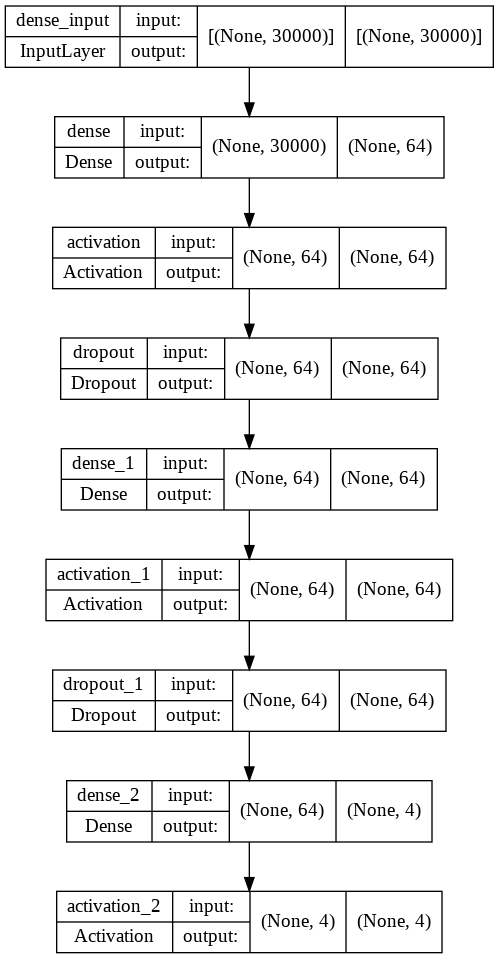

In [31]:
plot_model(model_ffn, show_shapes=True)

In [32]:
model_ffn.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy','accuracy'],
)

In [33]:
# We train (fit our data to) our model
history_ffn = model_ffn.fit(
    x=X_train_enc.todense(),           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc.todense(),               # the validation split that we did before
    y_val_enc),callbacks=callbacks_ffn
)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.54824, saving model to model_ffn.h5
220/220 - 5s - loss: 0.5838 - binary_accuracy: 0.6961 - accuracy: 0.2649 - val_loss: 0.5482 - val_binary_accuracy: 0.7273 - val_accuracy: 0.3521 - lr: 0.0010 - 5s/epoch - 21ms/step
Epoch 2/30

Epoch 00002: val_loss improved from 0.54824 to 0.47990, saving model to model_ffn.h5
220/220 - 1s - loss: 0.5009 - binary_accuracy: 0.7612 - accuracy: 0.3493 - val_loss: 0.4799 - val_binary_accuracy: 0.7695 - val_accuracy: 0.3777 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 3/30

Epoch 00003: val_loss improved from 0.47990 to 0.45645, saving model to model_ffn.h5
220/220 - 1s - loss: 0.3898 - binary_accuracy: 0.8250 - accuracy: 0.4570 - val_loss: 0.4565 - val_binary_accuracy: 0.7875 - val_accuracy: 0.4302 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.45645
220/220 - 1s - loss: 0.2775 - binary_accuracy: 0.8864 - accuracy: 0.5416 - val_loss: 0.4848 - val_binary_accu

## Model Evaluation

In [34]:
score_ffn = model_ffn.evaluate(
    X_val_enc.todense(),    # features
    y_val_enc,              # labels
    batch_size=batch_size,  # batch size
    verbose=2               # the most extended verbose
)

25/25 - 0s - loss: 0.4565 - binary_accuracy: 0.7875 - accuracy: 0.4302 - 94ms/epoch - 4ms/step


In [35]:
print('\nValidation binary_crossentropy: {}'.format(score_ffn[0]))
print('\nValidation binary_accuracy: {:.3f} %'.format(score_ffn[1]*100))
print('\nValidation accuracy: {:.3f} %'.format(score_ffn[2]*100))


Validation binary_crossentropy: 0.4564521610736847

Validation binary_accuracy: 78.745 %

Validation accuracy: 43.022 %


In [36]:
#save the weights of the model
model_ffn.save_weights('model_ffn_weights.h5')

In [37]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

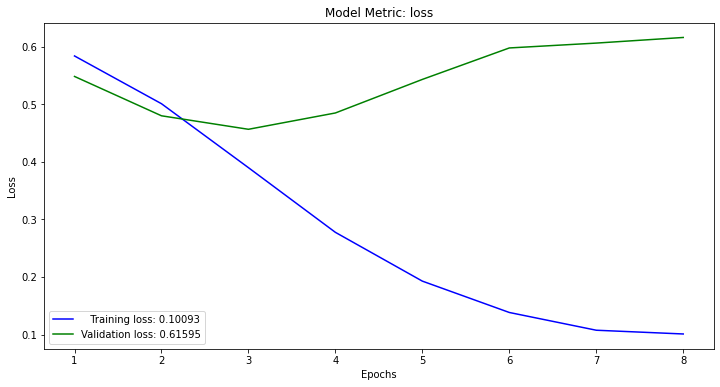

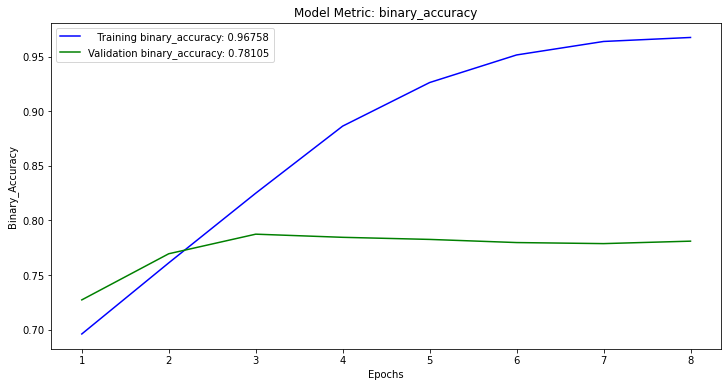

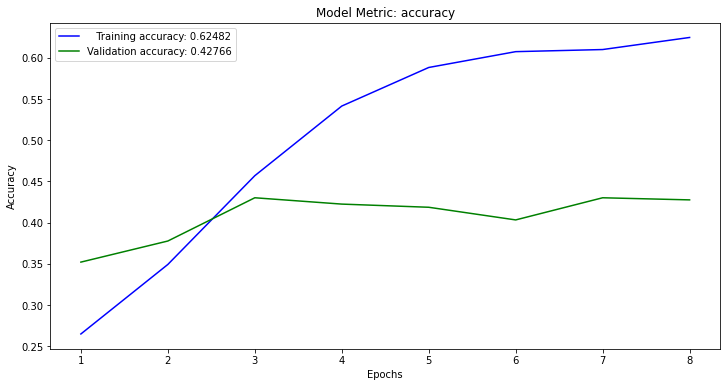

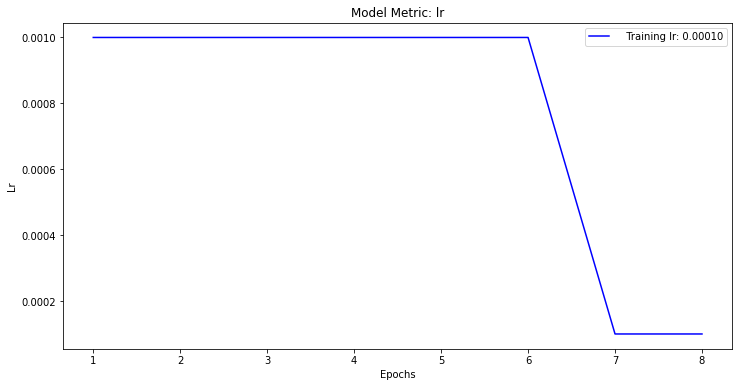

In [38]:
plot_keras_history(history_ffn)

# MLP Models with Word Embeddings.

In [ ]:
data['posts_length'] = data['posts'].apply(lambda x : len(x.split(' ')))

<Figure size 1152x576 with 0 Axes>

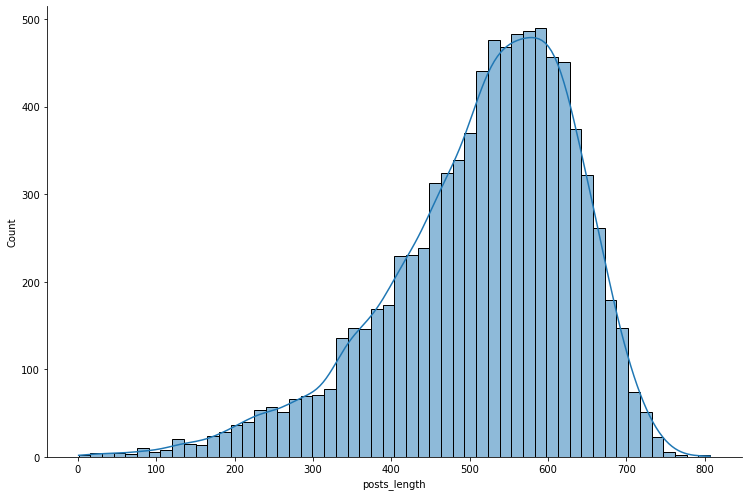

In [ ]:
plt.figure(figsize=(16,8))
sns.displot(data.posts_length,kde=True,height=7,aspect=1.5)
plt.show()

In [ ]:
print("Max :",data.posts_length.max())
print("Mean :",data.posts_length.mean())
print("Median :",data.posts_length.median())
print("Mode :",data.posts_length.mode())

Max : 807
Mean : 516.429855907781
Median : 537.0
Mode : 0    593
dtype: int64


## Tokenization and  Padding Process

In [ ]:
max_words = 30000

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_enc2  = tokenizer.texts_to_sequences(X_train)
X_val_enc2  = tokenizer.texts_to_sequences(X_val)
X_test_enc2  = tokenizer.texts_to_sequences(X_test)

In [ ]:
word_index = tokenizer.word_index

for w in ['ten', 'love', 'top']:
     print(f'Token for the word "{w}": {word_index[w]}')

Token for the word "ten": 1545
Token for the word "love": 221
Token for the word "top": 570


In [ ]:
maxlen = 540

X_train_enc2 = pad_sequences(X_train_enc2, maxlen=maxlen)
X_val_enc2 = pad_sequences(X_val_enc2, maxlen=maxlen)
X_test_enc2 = pad_sequences(X_test_enc2, maxlen=maxlen)

print('New data shape: {}'.format(X_train_enc2.shape))
print('New data shape: {}'.format(X_val_enc2.shape))
print('New data shape: {}'.format(X_test_enc2.shape))

New data shape: (7026, 540)
New data shape: (781, 540)
New data shape: (868, 540)


## MLP with Trainable Embedding Layer.


### Model Callbacks

In [ ]:
monitor = 'val_loss'

model_mlp_fname = 'model_mlp.h5'

callbacks_mlp = [
    
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_mlp_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]

In [ ]:
## model hyperparams
nb_classes = len(y_train_enc[0])

print('Number of Classes (Personality Components): {}'.format(nb_classes))

nb_epoch = 50

batch_size = 32

dropout_rate = 0.4

embed_dim = 300

Number of Classes (Personality Components): 4


### Model Architecture

In [ ]:
print('Building Model...')
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = max_words,  output_dim = embed_dim, embeddings_initializer='uniform',input_length = maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, input_shape=(max_words,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])
model_mlp.summary()

Building Model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 540, 300)          9000000   
                                                                 
 flatten (Flatten)           (None, 162000)            0         
                                                                 
 dense_3 (Dense)             (None, 32)                5184032   
                                                                 
 activation_3 (Activation)   (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 activation_4 (Activation)   (None, 

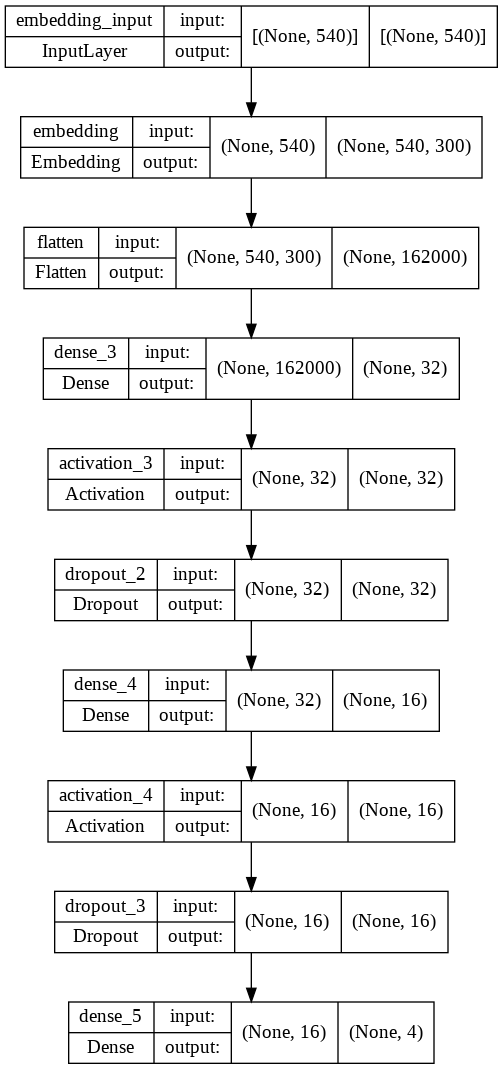

In [ ]:
plot_model(model_mlp, show_shapes=True)

In [ ]:
#compile model
model_mlp.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy','accuracy'],
)

In [ ]:
#fit train data to the model
history_mlp = model_mlp.fit(
    x=X_train_enc2,           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc2,               # the validation split that we did before
    y_val_enc),callbacks=callbacks_mlp
)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.58122, saving model to model_mlp.h5
220/220 - 3s - loss: 0.6253 - binary_accuracy: 0.6486 - accuracy: 0.2619 - val_loss: 0.5812 - val_binary_accuracy: 0.6946 - val_accuracy: 0.2650 - lr: 0.0010 - 3s/epoch - 15ms/step
Epoch 2/50

Epoch 00002: val_loss improved from 0.58122 to 0.57146, saving model to model_mlp.h5
220/220 - 2s - loss: 0.5483 - binary_accuracy: 0.7175 - accuracy: 0.3480 - val_loss: 0.5715 - val_binary_accuracy: 0.7045 - val_accuracy: 0.2843 - lr: 0.0010 - 2s/epoch - 11ms/step
Epoch 3/50

Epoch 00003: val_loss improved from 0.57146 to 0.55340, saving model to model_mlp.h5
220/220 - 2s - loss: 0.4710 - binary_accuracy: 0.7619 - accuracy: 0.4525 - val_loss: 0.5534 - val_binary_accuracy: 0.7109 - val_accuracy: 0.2945 - lr: 0.0010 - 2s/epoch - 11ms/step
Epoch 4/50

Epoch 00004: val_loss improved from 0.55340 to 0.54405, saving model to model_mlp.h5
220/220 - 2s - loss: 0.3945 - binary_accuracy: 0.8077 - accuracy: 0.5276 

### Model Evaluation

In [ ]:
score_mlp = model_mlp.evaluate(
    X_val_enc2,
    y_val_enc,          
    batch_size=batch_size,
    verbose=1)

25/25 [==============================] - 0s 3ms/step - loss: 0.5440 - binary_accuracy: 0.7225 - accuracy: 0.3431


In [ ]:
print('\nValidation binary_crossentropy: {}'.format(score_mlp[0]))
print('\nValidation binary_accuracy: {:.3f} %'.format(score_mlp[1]*100))
print('\nValidation accuracy: {:.3f} %'.format(score_mlp[2]*100))


Validation binary_crossentropy: 0.5440471172332764

Validation binary_accuracy: 72.247 %

Validation accuracy: 34.315 %


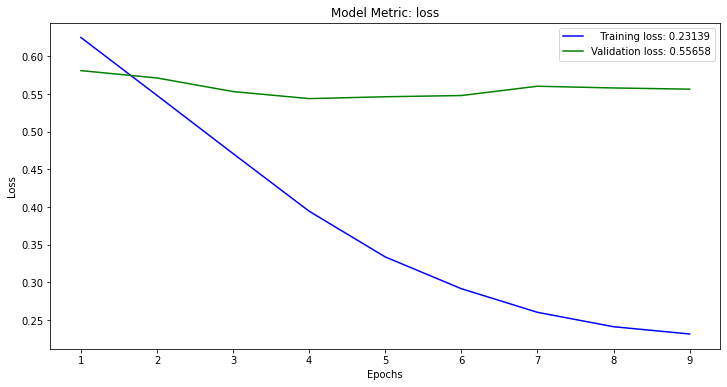

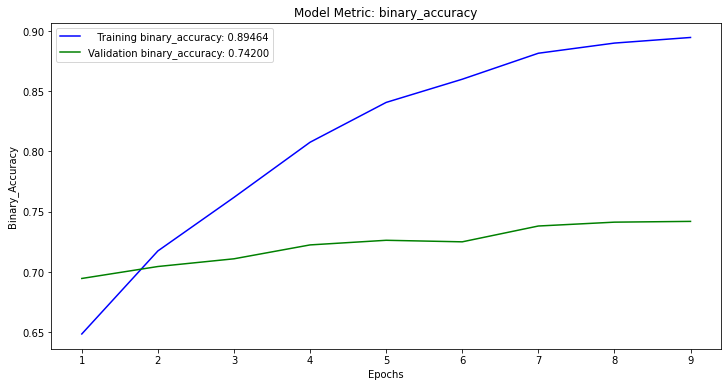

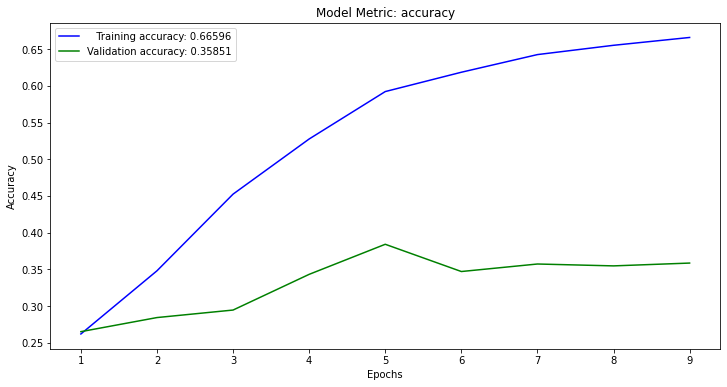

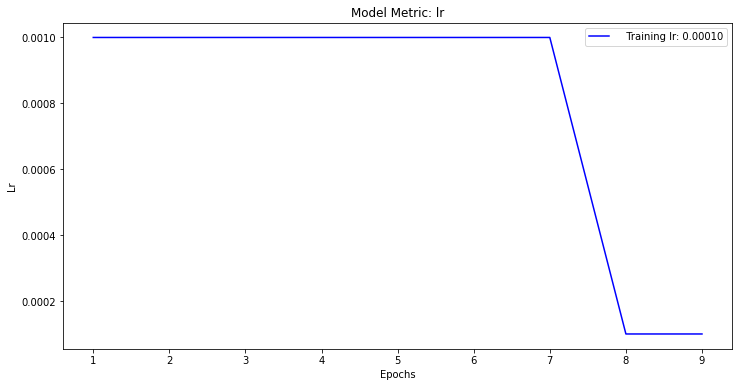

In [ ]:
plot_keras_history(history_mlp)

## Pretrained embeddings (Glove).

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-28 17:56:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-28 17:56:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-28 17:56:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [ ]:
embedding_dim = 300

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading word vectors


Loading Embeddings: 400000word [00:21, 18364.87word/s]

Found 400000 word vectors.


In [ ]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the glove embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [ ]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=tokenizer,
                                            emb_dim=embedding_dim)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 16253 pre-trained embeddings out of 30000


### Model Callbacks

In [ ]:
monitor = 'val_loss'

model_mlp2_fname = 'model_mlp2.h5'

callbacks_mlp2 = [
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_mlp2_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]

### Model Architecture

In [ ]:
## model hyperparams
nb_classes = len(y_train_enc[0])
dropout_rate = 0.4

print('Number of Classes (Personality Components): {}'.format(nb_classes))
print('Dropout Rate: {}'.format(dropout_rate))

# architecture hyperparameters
nb_epoch = 50
batch_size = 64 

Number of Classes (Personality Components): 4
Dropout Rate: 0.4


In [ ]:
print('Building Model...')
model_mlp2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, input_shape=(max_words,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])
model_mlp2.summary()

Building Model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 540, 300)          9000000   
                                                                 
 flatten_1 (Flatten)         (None, 162000)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               20736128  
                                                                 
 activation_5 (Activation)   (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 activation_6 (Activation)   (None, 

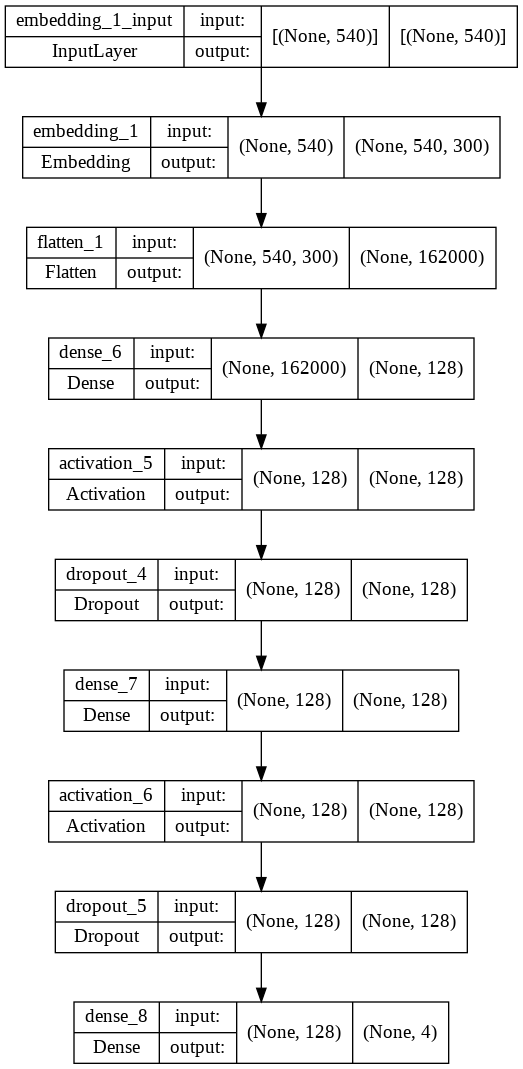

In [ ]:
plot_model(model_mlp2, show_shapes=True)

In [ ]:
#compile model
model_mlp2.compile(
    loss='binary_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy','accuracy'],
)

In [ ]:
#fit train data to the model
history_mlp2 = model_mlp2.fit(
    x=X_train_enc2,           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc2,               # the validation split that we did before
    y_val_enc),callbacks=callbacks_mlp2
)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.60345, saving model to model_mlp2.h5
110/110 - 2s - loss: 0.6967 - binary_accuracy: 0.6628 - accuracy: 0.2609 - val_loss: 0.6035 - val_binary_accuracy: 0.6873 - val_accuracy: 0.2766 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 2/50

Epoch 00002: val_loss improved from 0.60345 to 0.59251, saving model to model_mlp2.h5
110/110 - 2s - loss: 0.6228 - binary_accuracy: 0.6917 - accuracy: 0.2753 - val_loss: 0.5925 - val_binary_accuracy: 0.6933 - val_accuracy: 0.2791 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 3/50

Epoch 00003: val_loss improved from 0.59251 to 0.57882, saving model to model_mlp2.h5
110/110 - 2s - loss: 0.6026 - binary_accuracy: 0.6963 - accuracy: 0.2872 - val_loss: 0.5788 - val_binary_accuracy: 0.6937 - val_accuracy: 0.2753 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.57882
110/110 - 1s - loss: 0.5896 - binary_accuracy: 0.6951 - accuracy: 0.2966 - val_loss: 0.5789 - val_binary

### Model Evaluation

In [ ]:
score_mlp2 = model_mlp2.evaluate(
    X_val_enc2,
    y_val_enc,          
    batch_size=batch_size,
    verbose=1)

13/13 [==============================] - 0s 4ms/step - loss: 0.5763 - binary_accuracy: 0.6930 - accuracy: 0.2791


In [ ]:
print('\nValidation binary_crossentropy: {}'.format(score_mlp2[0]))
print('\nValidation binary_accuracy: {:.3f} %'.format(score_mlp2[1]*100))
print('\nValidation  accuracy: {:.3f} %'.format(score_mlp2[2]*100))


Validation binary_crossentropy: 0.5763341784477234

Validation binary_accuracy: 69.302 %

Validation  accuracy: 27.913 %


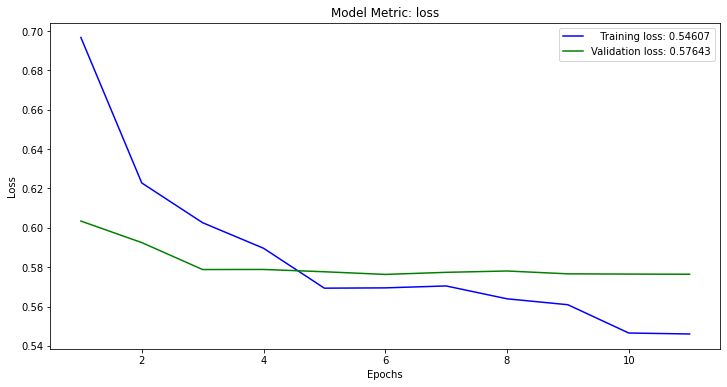

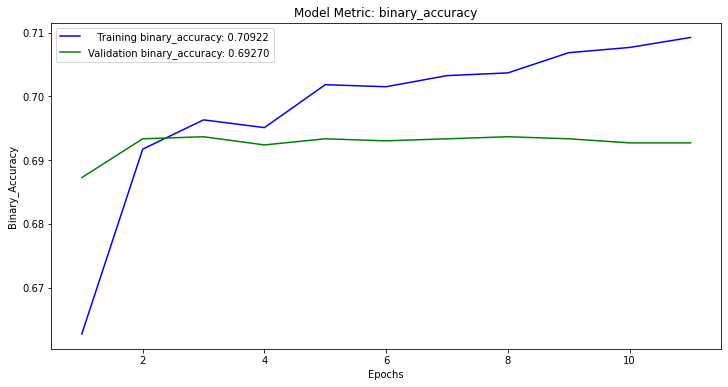

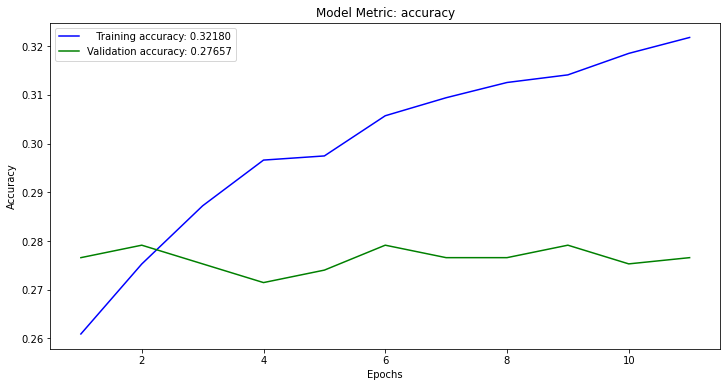

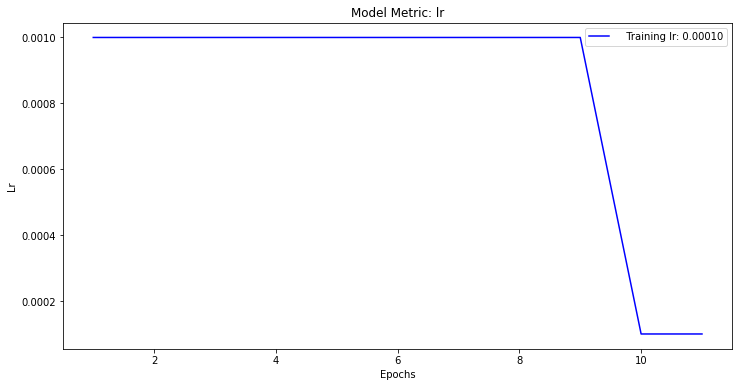

In [ ]:
plot_keras_history(history_mlp2)

# Bert Average Embeddings.

## Data Preparation.

In [ ]:
data = df.copy()

In [ ]:
data['tokens'] = data['posts'].apply(lambda s : s.split('|||'))
data = data.explode('tokens').reset_index()
data

,index,type,posts,tokens
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moments https://www.youtube.com...
3,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,What has been the most life-changing experienc...
4,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...
...,...,...,...,...
422840,8674,INFP,'It has been too long since I have been on per...,I was going to close my facebook a few months ...
422841,8674,INFP,'It has been too long since I have been on per...,30 Seconds to Mars - All of my collections. It...
422842,8674,INFP,'It has been too long since I have been on per...,"I have seen it, and i agree. I did actually th..."
422843,8674,INFP,'It has been too long since I have been on per...,Ok so i have just watched Underworld 4 (Awaken...


## Importing Bert from Tf Hub

In [ ]:
#! pip install tensorflow_hub
! pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

* Downloading the bert preprocessor and encoder from tf hub and assign them to variables

In [ ]:
# Load BERT and the preprocessing model from TF Hub.
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')


* Creating special hub keras layers in order to use them into a model.

In [ ]:
bert_preprocessor = hub.KerasLayer(preprocess)
bert_encoder = hub.KerasLayer(encoder)

* Example of berts tokenization of a random text.

In [ ]:
sample = ['Hello everyone what is going on?']
sample_pro = bert_preprocessor(sample)
sample_pro['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[ 101, 7592, 3071, 2054, 2003, 2183, 2006, 1029,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>

In [ ]:
#def get_sentence_embeding(sentences):
  #  preprocessed_text = bert_preprocessor(sentences)
   # return bert_encoder(preprocessed_text)['pooled_output']


In [ ]:
#l4 = tf.keras.layers.Dense(32, activation='relu', name="dense_2")(l3)
#l5= tf.keras.layers.Dropout(dropout_rate,name="dropout_2")(l4)

## Embedings Production

* Creating a model with functional api to produce embedingds from the posts of our dataset.
* Taking as input a text sample and passing it through berts preprocessor and encoder and giving as an output the correspoding embedding.

In [ ]:
#Bert embedings model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessed_text = bert_preprocessor(text_input)

outputs = bert_encoder(preprocessed_text)

embed = outputs['pooled_output']

model3 = tf.keras.Model(inputs= text_input, outputs = embed)

## Function using bert to produce average embedings for each user

* The fuction below produces for each user and each post an embedding and then the average embedding for each user average all the users post embeddings accordingly. 

In [ ]:
def bert_avg_emb():
  
  embedings =[]
  for i in range(0,8675,1):
    text = data['tokens'].loc[data['index'] == i]
    embeding = model3.predict(text,verbose=2)
    avg_embeding = pd.DataFrame(data=embeding).mean()
    
    embedings.append(avg_embeding)
  total = pd.DataFrame(embedings)  
  
  return total

total = bert_avg_emb()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
2/2 - 0s - 357ms/epoch - 178ms/step
2/2 - 0s - 345ms/epoch - 172ms/step
2/2 - 0s - 359ms/epoch - 179ms/step
2/2 - 0s - 363ms/epoch - 182ms/step
2/2 - 0s - 363ms/epoch - 181ms/step
2/2 - 0s - 358ms/epoch - 179ms/step
2/2 - 0s - 365ms/epoch - 183ms/step
2/2 - 0s - 364ms/epoch - 182ms/step
2/2 - 0s - 360ms/epoch - 180ms/step
2/2 - 0s - 359ms/epoch - 180ms/step
2/2 - 0s - 343ms/epoch - 171ms/step
2/2 - 0s - 363ms/epoch - 182ms/step
2/2 - 0s - 359ms/epoch - 180ms/step
2/2 - 0s - 358ms/epoch - 179ms/step
2/2 - 0s - 361ms/epoch - 180ms/step
2/2 - 0s - 356ms/epoch - 178ms/step
2/2 - 0s - 356ms/epoch - 178ms/step
2/2 - 0s - 358ms/epoch - 179ms/step
2/2 - 0s - 367ms/epoch - 184ms/step
2/2 - 0s - 362ms/epoch - 181ms/step
1/1 - 0s - 48ms/epoch - 48ms/step
2/2 - 0s - 372ms/epoch - 186ms/step
2/2 - 0s - 358ms/epoch - 179ms/step
2/2 - 0s - 368ms/epoch - 184ms/step
2/2 - 0s - 358ms/epoch - 179ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
2/2 - 0s - 35

In [ ]:
#total.to_csv('bert_embedings.csv', sep=',')

* This is the reading of the csv with the Bert embeddings.

In [ ]:
df_bert = pd.read_csv('bert_embedings.zip')
df_bert = pd.concat([df_bert,df['type']], axis=1)
df_bert = df_bert.drop(df_bert.columns[0],axis=1)
categories(df_bert)
df_bert.head()

In [ ]:
df_bert = pd.concat([total,df['type']], axis=1)

In [ ]:
categories(df_bert)

In [ ]:
df_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,type,Extraversion,Sensing,Thinking,Judging
0,-0.813585,-0.460146,-0.847922,0.690686,0.641749,-0.197525,0.708113,0.318758,-0.739252,-0.999876,...,0.023406,0.694017,-0.645879,-0.683867,0.824620,INFJ,0,0,0,1
1,-0.755586,-0.427686,-0.865838,0.654486,0.652495,-0.178787,0.620900,0.256498,-0.731647,-0.999877,...,-0.025313,0.707921,-0.724146,-0.638343,0.816752,ENTP,1,0,1,0
2,-0.781914,-0.375555,-0.684156,0.617958,0.441792,-0.164714,0.665724,0.261197,-0.510601,-0.999720,...,0.164810,0.650011,-0.503153,-0.655699,0.822973,INTP,0,0,1,0
3,-0.790165,-0.373552,-0.807944,0.675433,0.605761,-0.118477,0.700251,0.242395,-0.671328,-0.999883,...,0.069709,0.696613,-0.694381,-0.615460,0.832805,INTJ,0,0,1,1
4,-0.778633,-0.401281,-0.807603,0.678990,0.582415,-0.147827,0.690035,0.245059,-0.672122,-0.999696,...,0.026490,0.681111,-0.653950,-0.640830,0.799077,ENTJ,1,0,1,1


## Data Spliting 

In [ ]:
X = df_bert.iloc[:,0:768]
y = df_bert[['Extraversion','Sensing','Thinking','Judging']]
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.1,
                                                            random_state=20,
                                                            stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10, 
                                                  random_state=20,
                                                  stratify=y_train_val)

In [ ]:
X_train_enc = np.array(X_train)
X_val_enc = np.array(X_val)
X_test_enc = np.array(X_test)

In [ ]:
X_train_enc.shape

(7026, 768)

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler 

In [ ]:
scaler = StandardScaler()

* Scaling the average embedings for better peformance.


In [ ]:
X_train_enc_n = scaler.fit_transform(X_train_enc)
X_val_enc_n = scaler.transform(X_val_enc)
X_test_enc_n = scaler.transform(X_test_enc)

## Model Callbacks

In [ ]:
monitor = 'val_loss'

model_be_fname = 'model_be.h5'

callbacks_model_be = [
        
#     TensorBoard(log_dir=TENSORBOARD_LOGS_DIR,
#                 histogram_freq=0,
#                 embeddings_freq=0,
#                 write_graph=True,
#                 write_images=False),
    
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_be_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                       restore_best_weights=True)

]

## Model Architecture

* Trying alternative activation function (mish).

In [ ]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [ ]:
# model Hyperparams
nb_classes = len(y_train_enc[0])

print('Number of Classes (Personality Components): {}'.format(nb_classes))

nb_epoch = 30

batch_size = 32

dropout_rate = 0.40

max_features = 768


Number of Classes (Personality Components): 4


In [ ]:
print('Building Model...')

model_be = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(max_features,)),
    tf.keras.layers.Activation(activation=mish),
    tf.keras.layers.Dropout(dropout_rate),

    #tf.keras.layers.Dense(16, input_shape=(max_features,)),
    #tf.keras.layers.Activation(activation=mish),
    #tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])

print(model_be.summary())

Building Model...
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 512)               393728    
                                                                 
 activation_65 (Activation)  (None, 512)               0         
                                                                 
 dropout_65 (Dropout)        (None, 512)               0         
                                                                 
 dense_117 (Dense)           (None, 4)                 2052      
                                                                 
Total params: 395,780
Trainable params: 395,780
Non-trainable params: 0
_________________________________________________________________
None


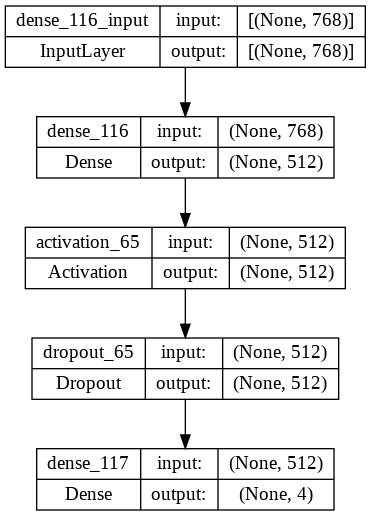

In [ ]:
plot_model(model_be, show_shapes=True)

In [ ]:
model_be.compile(
    loss='binary_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy','accuracy'],
)

In [ ]:
history_model_be = model_be.fit(
    x=X_train_enc_n,           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=1,               # the most extended verbosity level
    validation_data=(       
    X_val_enc_n,               # the validation split that we did before
    y_val_enc),
    callbacks=callbacks_model_be
)

Epoch 1/30
217/220 [============================>.] - ETA: 0s - loss: 0.4906 - binary_accuracy: 0.7688 - accuracy: 0.4215
Epoch 00001: val_loss did not improve from 0.46590
220/220 [==============================] - 4s 4ms/step - loss: 0.4907 - binary_accuracy: 0.7686 - accuracy: 0.4216 - val_loss: 0.5092 - val_binary_accuracy: 0.7599 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 2/30
209/220 [===========================>..] - ETA: 0s - loss: 0.4893 - binary_accuracy: 0.7682 - accuracy: 0.4206
Epoch 00002: val_loss did not improve from 0.46590
220/220 [==============================] - 1s 4ms/step - loss: 0.4890 - binary_accuracy: 0.7683 - accuracy: 0.4189 - val_loss: 0.4928 - val_binary_accuracy: 0.7692 - val_accuracy: 0.4302 - lr: 0.0010
Epoch 3/30
214/220 [============================>.] - ETA: 0s - loss: 0.4832 - binary_accuracy: 0.7734 - accuracy: 0.4182
Epoch 00003: val_loss did not improve from 0.46590
220/220 [==============================] - 1s 3ms/step - loss: 0.4840 - binary_ac

## Model Evaluation

In [ ]:
score_model_be = model_be.evaluate(
    X_val_enc_n,
    y_val_enc,          
    batch_size=batch_size,
    verbose=1)

25/25 [==============================] - 0s 3ms/step - loss: 0.4643 - binary_accuracy: 0.7846 - accuracy: 0.4251


In [ ]:
print('\nValidation binary_crossentropy: {}'.format(score_model_be[0]))
print('\nValidation binary_accuracy: {:.3f} %'.format(score_model_be[1]*100))
print('\nValidation  accuracy: {:.3f} %'.format(score_model_be[2]*100))


Validation binary_crossentropy: 0.4642564058303833

Validation binary_accuracy: 78.457 %

Validation  accuracy: 42.510 %


In [ ]:
#save the weights of the model
model_be.save_weights('model_bert_weights.h5')

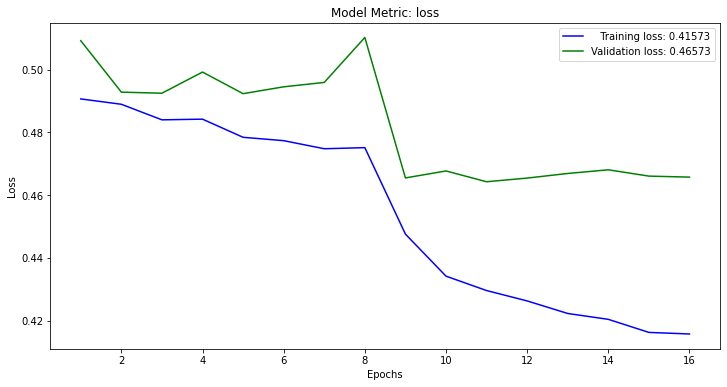

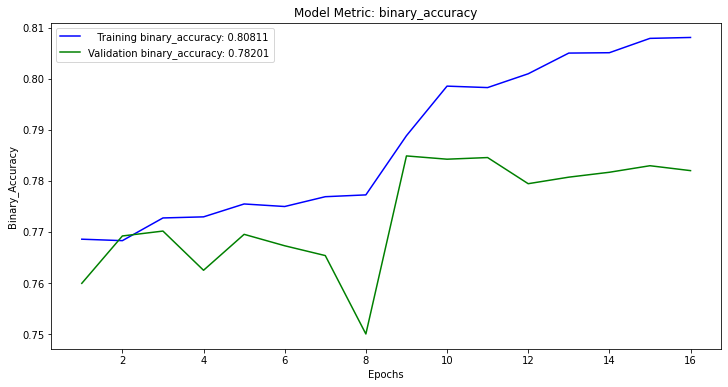

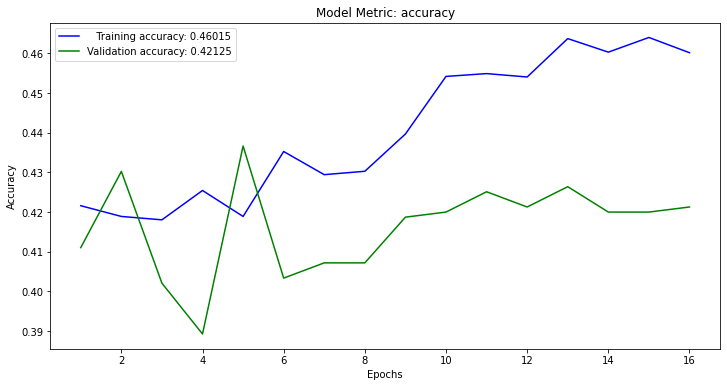

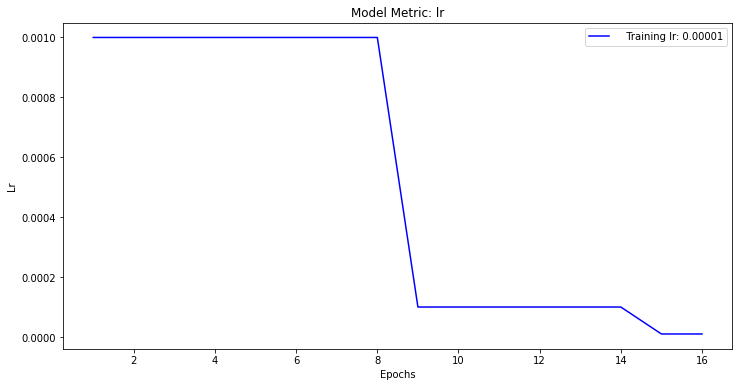

In [ ]:
plot_keras_history(history_model_be)

## Conclusion 

As we can observe, in this notebook we implemented four different MLP models, one Feed Forward Neural Network with bag of words approach, one MLP model with trainable embeddings, one MLP model with GLOVE embeddings and one MLP model with Bert embeddings. These models performed quite well.Especially, the FFN one and the MLP model with BERT embeddings resulted in a quite high score compared to other approaches. Their evaluation summary can be found right below :

***FFN model with bag of words approach:***

Validation binary crossentropy: 0.456

Validation binary_accuracy: 78.74 %

Validation accuracy: 43.02 %


***MLP model with trainable embeddings:***


Validation binary crossentropy: 0.544

Validation binary accuracy: 72.24 %

Validation accuracy: 34.31 %


***MLP model with GLOVE embeddings:***


Validation binary crossentropy: 0.576

Validation binary accuracy: 69.30 %

Validation  accuracy: 27.91 %


***MLP model with BERT embeddings:***

Validation binary crossentropy: 0.464

Validation binary accuracy: 78.45 %

Validation  accuracy: 42.51 %